<a href="https://colab.research.google.com/github/vveitch/causality-tutorials/blob/main/Sensitivity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensitivity Analysis Tutorial

This tutorial gives a short example for how to assess sensitivity to unobserved confounding in causal estimation. We use the Austen plot method (https://arxiv.org/abs/2003.01747). 

In [62]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os
import pathlib

from austen_plots.AustenPlot import AustenPlot

In [63]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os

In [64]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ATE and ATT Estimation with Double Machine Learning

In [65]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
import sklearn
import os

In [66]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

##Load and Format Our Data (including treatment and instrument variables)

In [67]:
def make_data_covid_lockdown(df):
    df_new = df.copy()
    df_new['treatment'] = (df['tenure'] >= 3).astype(int)
    df_new['outcome'] = (df['xc_lockdown']).astype(int)
    return df_new

col_names = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'ct_shortname', 'prov',
              'citycode', 'ctnm', 'centlon', 'centlat', 'locked_down',
              'lockdown_date', 'bdidx_19m20', 'xc_lockdown', 'xc_closed',
              'daySinceFirstCase', 'sub_prov_ct', 'gdp2018', '自治州-盟-地区', 'in_291',
              'pdensity', 'gdp_p', 'hospital_d', 'popHR18_all', 'Log_popHR18_all',
              'gdp_per_10k', 'primary_ind', 'second_ind', 'third_ind',
              'prov_leader_rank', 'num_hospital_total', 'num_doctors_total',
              'num_firm_total', 'non_domestic_firms_total',
              'pct_of_non_domestic_firm', 'primary_emp_share_total',
              'secondary_emp_share_total', 'tertiary_emp_share_total', 'inaug_time',
              'birthmonth', 'is_female', 'age_feb20', 'party_age', 'work_age',
              'tenure', 'majorchara', 'is_STEM_major', 'rule_in_native_prov', 'is_BA',
              'is_MA', 'is_PhD', 'cumulative_case', 'log_cumulative_case',
              'bdidx_19m20_feb1_10', 'lockdown_datenum', 'xc_lockdown_datenum',
              'xc_closed_datenum', 'hu_liao_jiang_nei', 'mayor', 'mayor_age',
              'mayor_work_age', 'xunshi', 'treatment', 'outcome']

dataset = pd.read_csv("/Users/qitianhu/Documents/Research/Explore/COVID-19_sosc/STAT274/IVdata-1.csv")
data = make_data_covid_lockdown(dataset)

In [68]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ct_shortname,prov,citycode,ctnm,centlon,centlat,locked_down,...,lockdown_datenum,xc_lockdown_datenum,xc_closed_datenum,hu_liao_jiang_nei,mayor,mayor_age,mayor_work_age,xunshi,treatment,outcome
0,0,0,0,七台河,黑龙江省,230900,七台河市,130.862488,45.896891,0,...,30.0,30.0,30.0,0,贾君,56,38,1,0,0
1,1,1,1,三亚,海南省,460200,三亚市,109.418152,18.391594,0,...,30.0,30.0,5.0,0,阿东,49,22,1,0,0
2,2,2,2,三明,福建省,350400,三明市,117.395196,26.299947,0,...,30.0,30.0,30.0,0,余红胜,49,29,1,0,0
3,3,3,3,三门峡,河南省,411200,三门峡市,111.106682,34.362922,0,...,30.0,30.0,0.0,0,安伟,53,28,1,1,0
4,4,4,4,上饶,江西省,361100,上饶市,117.469239,28.774557,1,...,6.0,6.0,6.0,1,陈云,43,20,0,1,1


In [69]:
# confounder_fields = ['age_feb20']
confounder_fields = ['sub_prov_ct', 'gdp_per_10k', 'primary_emp_share_total']

confounders = data[confounder_fields]
outcome = data['outcome']
treatment = data['treatment']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = data['treatment'], outcome
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

print(clf.predict([[0, 0, 0, 0]]))

## Specify Nuisance Function Models

The next step is to specify models for the conditional expected outcome and propensity score.

In [70]:
# specify a model for the conditional expected outcome

# make a function that returns a sklearn model for later use in k-folding
def make_Q_model():
  # return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)
  return LinearRegression()
Q_model = make_Q_model()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Q_model.fit(X_train, y_train)
y_pred = Q_model.predict(X_test)

test_mse=mean_squared_error(y_pred, y_test)
print(f"Test MSE of fit model {test_mse}") 
baseline_mse=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse}")

Test MSE of fit model 0.23863223988188328
Test MSE of no-covariate model 0.2315443252770688


In [71]:
# specify a model for the propensity score

def make_g_model():
  # return LogisticRegression(max_iter=1000)
  return RandomForestClassifier(n_estimators=100, max_depth=5)
  # return LogisticRegression()

g_model = make_g_model()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_train, X_test, a_train, a_test = train_test_split(confounders, treatment, test_size=0.2)
g_model.fit(X_train, a_train)
a_pred = g_model.predict_proba(X_test)[:,1]

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}") 
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")

Test CE of fit model 0.5517525136875073
Test CE of no-covariate model 0.6012863511154858


## Use cross fitting to get predicted outcomes and propensity scores for each unit

In [72]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [73]:
g = treatment_k_fold_fit_and_predict(make_g_model, X=confounders, A=treatment, n_splits=10)

In [74]:
Q0,Q1=outcome_k_fold_fit_and_predict(make_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="continuous")

In [75]:
data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
data_and_nuisance_estimates.head()

,g,Q0,Q1,A,Y
0,0.364386,0.387523,0.382180,0,0
1,0.226323,0.293117,0.284594,0,0
2,0.258593,0.382525,0.429794,0,0
3,0.334712,0.416111,0.379516,1,0
4,0.407760,0.413713,0.408370,1,1


## Combine predicted values and data into estimate of ATT


In [76]:
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATT
  This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
  """

  if prob_t is None:
    prob_t = A.mean() # estimate marginal probability of treatment

  tau_hat = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0)).mean()/ prob_t
  
  scores = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0) - tau_hat*A) / prob_t
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


In [77]:
def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATE
  """

  tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
  scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


In [78]:
tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates)
print(f"The estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.01689725532207073 pm 0.15679728766901185


In [79]:
in_treated = data_and_nuisance_estimates['A']==1
treated_estimates = data_and_nuisance_estimates[in_treated]
tau_hat, std_hat = ate_aiptw(**treated_estimates)
print(f"The estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.004660799590979019 pm 0.40944720936020307


In [80]:
# Computing the estimate restricted to a population with only reasonable propensity scores
g = data_and_nuisance_estimates['g']
in_overlap_popluation = ((g > 0.05) & (g < 0.95))
overlap_data_and_nuisance = data_and_nuisance_estimates[in_overlap_popluation]
tau_hat, std_hat = att_aiptw(**overlap_data_and_nuisance)
print(f"The estimate is {tau_hat} pm {1.96*std_hat}")

The estimate is 0.01696749912481328 pm 0.15679491643795543


# Sensitivity stuff

#Sensitivity Analysis

We found an average treatment effect of diastolic blood pressure medication of about 2, significant at the 0.95 level. We'd now conduct some analysis to decide how sensitive this conclusions is to possible unobserved confounding.

In [81]:
# the first step is to choose a level of bias that would undermine the qualitative conclusion of the study
# we'll go with the nominal effect
target_bias = 0.200 # note: bias is specified as an absolute number

## Compute influence strength of covariates
Our task is to assess whether it's plausible that an unobserved confounder could be strong enough to induce a bias of 2 or more. To make that easier, we'd like to know how strong the observed confounders are. Austen plots computes these reference strengths by seeing how much model performance degrades when the covariates are removed. Accordingly, we refit the models with each (group of) reference covariate removed.  

In [96]:
# First, lets define the groups of covariates we'll measure the strength of.
# Note: it's important to group the covariates into meaningful groups, because strength is measured conditional on all remaining covariates
# E.g., if we remove only "black" (and not "hispanic, white") then we will measure no effect, because we can infer the removed variable from the remaining ones

covariate_groups = {
    'political': ['sub_prov_ct'],
    # 'economic size': ['gdp_per_10k'],
    'economic structure': ['primary_emp_share_total']}
   #  , 'gdp_p', 'hospital_d', 'popHR18_all', 'Log_popHR18_all',
   #     'gdp_per_10k', 'primary_ind', 'second_ind', 'third_ind',
   #     'prov_leader_rank', 'num_hospital_total', 'num_doctors_total',
   #     'num_firm_total', 'non_domestic_firms_total',
   #     'pct_of_non_domestic_firm', 'primary_emp_share_total',
   #     'secondary_emp_share_total', 'tertiary_emp_share_total'],
   #  'secretary': ['birthmonth', 'is_female', 'age_feb20', 'party_age', 'work_age',
   #     'tenure', 'majorchara', 'is_STEM_major', 'rule_in_native_prov', 'is_BA',
   #     'is_MA', 'is_PhD'],
   #  'covid':['cumulative_case', 'log_cumulative_case'],
   #  'age': ['age_mo']}

#  'inaug_time',
#        , 
#        'bdidx_19m20_feb1_10', 'lockdown_datenum', 'xc_lockdown_datenum',
#        'xc_closed_datenum', 'hu_liao_jiang_nei', 'mayor', 'mayor_age'

In [97]:
# For each covariate group, refit the models without using that group
nuisance_estimates = {}
for group, covs in covariate_groups.items():
  remaining_confounders = confounders.drop(columns=covs)

  g = treatment_k_fold_fit_and_predict(make_g_model, X=remaining_confounders, A=treatment, n_splits=5)
  Q0, Q1 = outcome_k_fold_fit_and_predict(make_Q_model, X=remaining_confounders, y=outcome, A=treatment, n_splits=5, output_type="continuous")

  data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
  nuisance_estimates[group] = data_and_nuisance_estimates


## Save computed estimates as CSVs
The Austen plot code expects the nuisance function estimates to be provided as csvs with columns 'g', 'Q', 't', 'y'

In [98]:
data_and_nuisance_path = 'data_and_nuisance_estimates.csv'
covariate_dir_path = 'covariates/'

In [99]:
def _convert_to_austen_format(nuisance_estimate_df: pd.DataFrame):
  austen_df = pd.DataFrame()
  austen_df['y']=nuisance_estimate_df['Y']
  austen_df['t']=nuisance_estimate_df['A']
  austen_df['g']=nuisance_estimate_df['g']
  A = nuisance_estimate_df['A']
  austen_df['Q']=A*nuisance_estimate_df['Q1'] + (1-A)*nuisance_estimate_df['Q0'] # use Q1 when A=1, and Q0 when A=0

  return austen_df

In [100]:
austen_data_and_nuisance = _convert_to_austen_format(data_and_nuisance_estimates)
austen_data_and_nuisance.to_csv(data_and_nuisance_path, index=False)

pathlib.Path(covariate_dir_path).mkdir(exist_ok=True)
for group, nuisance_estimate in nuisance_estimates.items():
  austen_nuisance_estimate = _convert_to_austen_format(nuisance_estimate)
  austen_nuisance_estimate.to_csv(os.path.join(covariate_dir_path,group+".csv"), index=False)

## Make plots

In [101]:
ap = AustenPlot(data_and_nuisance_path, covariate_dir_path)

In [102]:
target_bias=1

p, plot_coords, variable_coords = ap.fit(bias=1) # recall we set target_bias=2.0

Fitting main dataset


/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/qitianhu/opt/anaconda3/lib/python3.8/site-packages/austen_plots/math_helpers.py:18: Run

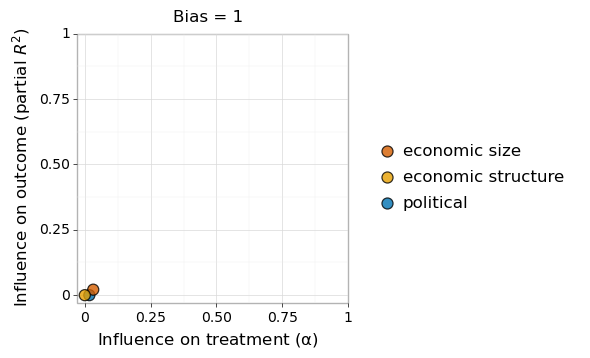

<ggplot: (8768770922274)>

In [103]:
p